# TFX for TensorFlow Serving

- [Servers: TFX for TensorFlow Serving](https://www.tensorflow.org/tfx/tutorials/serving/rest_simple)

In [1]:
import sys

# Confirm that we're using Python 3
assert sys.version_info.major == 3, 'Oops, not running Python 3. Use Runtime > Change runtime type'

In [2]:
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

print(f'TensorFlow version: {tf.__version__}')
print(f'TensorFlow GPU support: {tf.test.is_built_with_gpu_support()}')

physical_gpus = tf.config.list_physical_devices('GPU')
print(physical_gpus)
for gpu in physical_gpus:
  # memory growth must be set before GPUs have been initialized
  tf.config.experimental.set_memory_growth(gpu, True)
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(len(physical_gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

TensorFlow version: 2.4.1
TensorFlow GPU support: True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


## Create your model

### Import the Fashion MNIST dataset

- [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist)

In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# scale the values to 0.0 to 1.0
train_images = train_images / 255.0
test_images = test_images / 255.0

# reshape for feeding into the model
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('\ntrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))


train_images.shape: (60000, 28, 28, 1), of float64
test_images.shape: (10000, 28, 28, 1), of float64


### Train and evaluate your model

Let's use the simplest possible CNN, since we're not focused on the modeling part.

In [4]:
model = keras.Sequential([
  keras.layers.Conv2D(input_shape=(28,28,1), filters=8, kernel_size=3, 
                      strides=2, activation='relu', name='Conv1'),
  keras.layers.Flatten(),
  keras.layers.Dense(10, name='Dense')
])
model.summary()

testing = False
epochs = 5

model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(train_images, train_labels, epochs=epochs)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print('\nTest accuracy: {}'.format(test_acc))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 13, 13, 8)         80        
_________________________________________________________________
flatten (Flatten)            (None, 1352)              0         
_________________________________________________________________
Dense (Dense)                (None, 10)                13530     
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1875/1875 [==============================] - 3s 722us/step - loss: 0.7387 - sparse_categorical_accuracy: 0.7449
Epoch 2/5
1875/1875 [==============================] - 1s 793us/step - loss: 0.4561 - sparse_categorical_accuracy: 0.8408
Epoch 3/5
1875/1875 [==============================] - 1s 720us/step - loss: 0.4097 - sparse_categorical_accuracy: 0.8566
Epoch 4/5
1875/1

## Save your model

To load our trained model into TensorFlow Serving we first need to save it in [SavedModel](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/saved_model) format. This will create a protobuf file in a well-defined directory hierarchy, and will include a version number.

[TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving) allows us to select which version of a model, or "servable" we want to use when we make inference requests. Each version will be exported to a different sub-directory under the given path.

In [5]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
import tempfile

MODEL_DIR = os.path.join(tempfile.gettempdir(), 'tfx')
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/tfx/1

INFO:tensorflow:Assets written to: /tmp/tfx/1/assets

Saved model:
total 88
drwxr-xr-x 2 john john  4096 Apr 13 15:10 assets
-rw-rw-r-- 1 john john 78169 Apr 13 15:12 saved_model.pb
drwxr-xr-x 2 john john  4096 Apr 13 15:12 variables


## Examine your saved model

We'll use the command line utility `saved_model_cli` to look at the [MetaGraphDefs](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/MetaGraphDef) (the models) and [SignatureDefs](https://www.tensorflow.org/tfx/tutorials/signature_defs) (the methods you can call) in our SavedModel. See [this discussion of the SavedModel CLI](https://github.com/tensorflow/docs/blob/master/site/en/r1/guide/saved_model.md#cli-to-inspect-and-execute-savedmodel) in the TensorFlow Guide.

In [6]:
!saved_model_cli show --dir '/tmp/tfx/1' --all

2021-04-13 15:12:29.433576: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['Conv1_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_Conv1_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['Dense'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensor

## Serve your model with TensorFlow Serving


> This example is running TensorFlow Serving natively, but [you can also run it in a Docker container](https://www.tensorflow.org/tfx/serving/docker), which is one of the easiest ways to get started using TensorFlow Serving.

### Add TensorFlow Serving distribution URI as a package source

In [7]:
import sys
# We need sudo prefix if not on a Google Colab.
if 'google.colab' not in sys.modules:
  SUDO_IF_NEEDED = 'sudo'
else:
  SUDO_IF_NEEDED = ''

In [8]:
# This is the same as you would do from your command line, but without the [arch=amd64], and no sudo
# You would instead do:
# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

# echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | {SUDO_IF_NEEDED} tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | {SUDO_IF_NEEDED} apt-key add -
# !{SUDO_IF_NEEDED} apt update

### Install TensorFlow Serving

In [9]:
# !{SUDO_IF_NEEDED} apt-get install tensorflow-model-server

### Start running TensorFlow Serving

This is where we start running TensorFlow Serving and load our model. After it loads we can start making inference requests using REST. There are some important parameters:

- `rest_api_port`: The port that you'll use for REST requests.
- `model_name`: You'll use this in the URL of REST requests. It can be anything.
- `model_base_path`: This is the path to the directory where you've saved your model.

In [10]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [11]:
# nohup tensorflow_model_server \
#   --rest_api_port=8501 \
#   --model_name=fashion_model \
#   --model_base_path="/tmp/tfx" >server.log 2>&1 &

In [12]:
! tail server.log

To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-04-13 15:12:10.706648: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:206] Restoring SavedModel bundle.
2021-04-13 15:12:10.726722: I external/org_tensorflow/tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599990000 Hz
2021-04-13 15:12:10.756506: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:190] Running initialization op on SavedModel bundle at path: /tmp/tfx/1
2021-04-13 15:12:10.759935: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:277] SavedModel load for tags { serve }; Status: success: OK. Took 110653 microseconds.
2021-04-13 15:12:10.760277: I tensorflow_serving/servables/tensorflow/saved_model_warmup_util.cc:59] No warmup data file found at /tmp/tfx/1/assets.extra/tf_serving_warmup_requests
2021-04-13 15:12:10.760486: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: fas

## Make a request to your model in TensorFlow Serving

First, let's take a look at a random example from our test data.

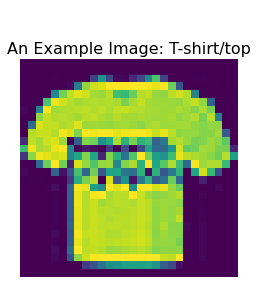

In [13]:
def show(idx, title):
  plt.figure()
  plt.imshow(test_images[idx].reshape(28,28))
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

import random
rando = random.randint(0,len(test_images)-1)
show(rando, 'An Example Image: {}'.format(class_names[test_labels[rando]]))

Ok, that looks interesting. How hard is that for you to recognize? Now let's create the JSON object for a batch of three inference requests, and see how well our model recognizes things:

In [14]:
import json
data = json.dumps({"signature_name": "serving_default", "instances": test_images[0:3].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ...  [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]]}


## Make REST requests

### Newest version of the servable

We'll send a predict request as a POST to our server's REST endpoint, and pass it three examples. We'll ask our server to give us the latest version of our servable by not specifying a particular version.

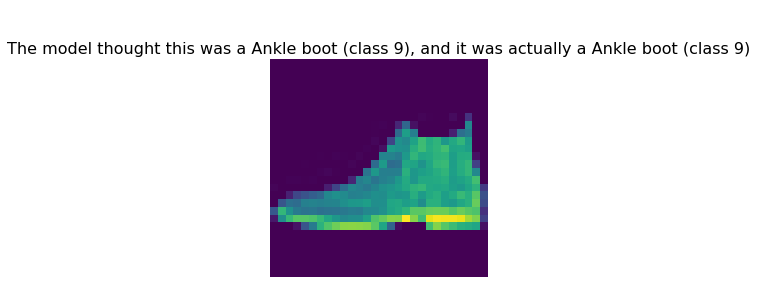

In [15]:
!pip install -q requests

import requests
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

show(0, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
  class_names[np.argmax(predictions[0])], np.argmax(predictions[0]), class_names[test_labels[0]], test_labels[0]))

### A particular version of the servable

Now let's specify a particular version of our servable. Since we only have one, let's select version 1. We'll also look at all three results.

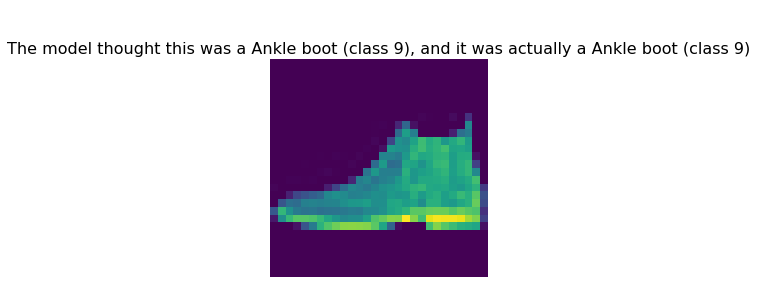

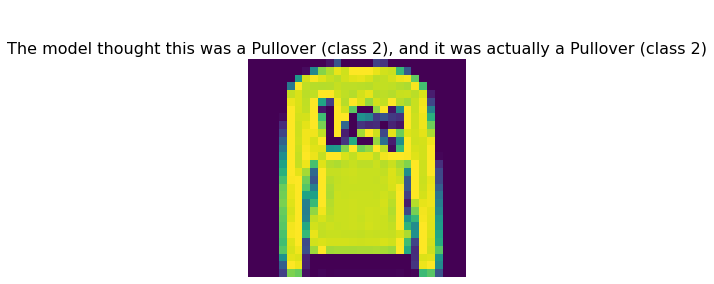

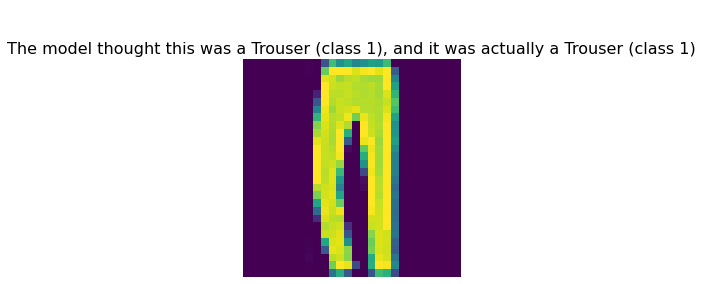

In [16]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion_model/versions/1:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

for i in range(0,3):
  show(i, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
    class_names[np.argmax(predictions[i])], np.argmax(predictions[i]), class_names[test_labels[i]], test_labels[i]))